In [1]:
import numpy as np
import time
import math
#-------------------------------
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [2]:
def train(x_train, y_train, x_test, y_test, hpar):
    input_shape = x_train.shape[1:]
    output_num = y_train.shape[1]
    if hpar['activation_last_layer'] == 'sigmoid': # loss function
        loss = 'binary_crossentropy'
    elif hpar['activation_last_layer'] == 'softmax':
        loss = 'categorical_crossentropy'
    if hpar['optimizer'] == 'gradient descent': # optimizer
        optimizer = SGD(lr=hpar['learning_rate'])
    elif hpar['optimizer'] == 'adam':
        optimizer = Adam(lr=hpar['learning_rate'])
    #-----------------------------------------------------
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    for i in range(len(hpar['hidden_layer_dims'])):
        model.add(Dense(hpar['hidden_layer_dims'][i]))
        model.add(BatchNormalization())
        model.add(Activation(hpar['activation_hidden_layers'])) # 'sigmoid', 'tanh', 'relu'
    model.add(Dense(output_num))
    model.add(BatchNormalization())
    model.add(Activation(hpar['activation_last_layer']))
    model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
    #-----------------------------------------------------
    model.summary()
    loss = []
    accu = []
    for i in range(1, 1 + max(1, hpar['num_epochs'] // hpar['print_cost'])):
        tic = time.time()
        fout = model.fit(x_train, y_train, epochs=hpar['print_cost'], batch_size=hpar['minibatch_size'], class_weight=hpar['class_weight'], verbose=0)
        toc = time.time()
        loss = loss + fout.history['loss']
        accu = accu + fout.history['acc']
        score_train = model.evaluate(x_train, y_train, batch_size=hpar['minibatch_size'], verbose=0)
        score_test = model.evaluate(x_test, y_test, batch_size=hpar['minibatch_size'], verbose=0)
        print('>> epochs = ', (i*hpar['print_cost']),'; Train loss/acc = %f/%f'%(score_train[0],score_train[1]), '; Test loss/acc = %f/%f'%(score_test[0],score_test[1]), '; time = %f sec '%(toc-tic))
    mout = {'model': model,
            'loss': loss,
            'accu': accu}
    return mout

x_train =  (700, 2)
y_train =  (700, 1)
x_test =  (300, 2)
y_test =  (300, 1)
y_train_one_hot =  (700, 2)
y_test_one_hot =  (300, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 2)                 8         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                60        
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
batch_normalization_3 (Batch (None, 10)                40        
_________

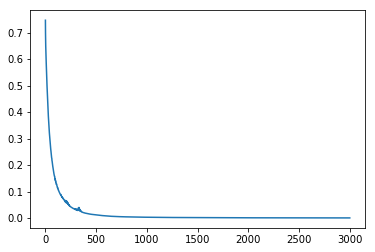

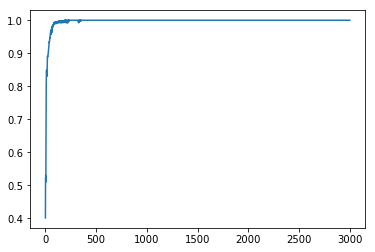

0.98


In [3]:
def generate_2D_dataset(num_sample = 1000, seed = 1):
    np.random.seed(seed)
    X = np.random.rand(2, num_sample)
    #Y = np.int32((X[1,:] - X[0,:] + 0.3) > 0).reshape(1, num_sample)  # line
    #Y = np.int32((X[0,:]**2 + X[1,:]**2 - 0.7**2) > 0).reshape(1, num_sample) # semi-circle
    #Y = np.int32(((X[0,:]-0.5)**2 + (X[1,:]-0.5)**2 - 0.3**2) > 0).reshape(1, num_sample)  # circle
    #Y = np.int32((((X[0,:]-0.5)/0.4)**2 + ((X[1,:]-0.2)/0.05)**2 - 1) > 0).reshape(1, num_sample)  # ellipse
    Y = np.int32(((((X[0,:]-0.5)/0.4)**2 + ((X[1,:]-0.2)/0.05)**2 - 1) > 0) & (((X[0,:]-0.7)**2 + (X[1,:]-0.7)**2 - 0.1**2) > 0)).reshape(1, num_sample) # ellipse & circle
    #-----------------------------------------------------------------
    rn = np.random.permutation(num_sample)
    NofT = math.floor(num_sample * 0.7) # number of train samples
    X_train = X[:,rn[0:NofT]]
    Y_train = Y[:,rn[0:NofT]]
    X_test = X[:,rn[NofT:]]
    Y_test = Y[:,rn[NofT:]]
    return X_train, Y_train, X_test, Y_test
def convert_keras_input(X_train, Y_train, X_test, Y_test):
    x_train = X_train.T
    y_train = Y_train.T
    x_test = X_test.T
    y_test = Y_test.T
    y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=2)
    y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=2)
    print("x_train = ", x_train.shape)
    print("y_train = ", y_train.shape)
    print("x_test = ", x_test.shape)
    print("y_test = ", y_test.shape)
    print("y_train_one_hot = ", y_train_one_hot.shape)
    print("y_test_one_hot = ", y_test_one_hot.shape)
    return x_train, y_train, x_test, y_test, y_train_one_hot, y_test_one_hot

if False:
    import matplotlib.pyplot as plt

    X_train, Y_train, X_test, Y_test = generate_2D_dataset()
    x_train, y_train, x_test, y_test, y_train_one_hot, y_test_one_hot = convert_keras_input(X_train, Y_train, X_test, Y_test)
    #-------------------------------------------------------------
    hpar = {}
    hpar['hidden_layer_dims'] = [20,10,5]
    hpar['activation_hidden_layers'] = ['sigmoid', 'tanh', 'relu'][2]
    hpar['activation_last_layer'] = ['sigmoid', 'softmax'][1]
    hpar['learning_rate'] = 0.01
    hpar['num_epochs'] = 3000
    hpar['minibatch_size'] = 999999
    hpar['optimizer'] = ["gradient descent", "momentum", "adam"][2]
    hpar['class_weight'] = None
    hpar['print_cost'] = 1000 # print epoch step; no print when it is zero
    mout = train(x_train, y_train_one_hot, x_test, y_test_one_hot, hpar)
    #-------------------------------------------------------------
    plt.plot(mout['loss'])
    plt.show()
    plt.plot(mout['accu'])
    plt.show()
    #-------------------------------------------------------------
    yp_test_one_hot = mout['model'].predict(x_test)
    yp_test = np.argmax(yp_test_one_hot, axis = 1).reshape(y_test.shape)
    accuracy_test = np.mean(y_test == yp_test)
    print(accuracy_test)  